In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [3]:
using_colab = False

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

In [83]:
IMAGE_FILE = './images/soybean.jpeg'
image = cv2.imread(IMAGE_FILE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [84]:
#@markdown We implemented some functions to visualize the object detection results. <br/> Run the following cell to activate the functions.
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return image

In [85]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an ObjectDetector object.
base_options = python.BaseOptions(model_asset_path='efficientdet_lite0.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options,
                                       score_threshold=0.5)
detector = vision.ObjectDetector.create_from_options(options)

# STEP 3: Load the input image.
img = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect objects in the input image.
detection_result = detector.detect(img)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(img.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

I0000 00:00:1714693480.900210 12513161 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2


In [86]:
detections = detection_result.detections
for detection in detections:
    if 'plant' in detection.categories[0].category_name.lower():
        box = detection.bounding_box

input_box = np.array([box.origin_x, box.origin_y, box.origin_x+box.width, box.origin_y+box.height])

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [87]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [88]:
predictor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [71]:
#input_box = np.array([425, 600, 700, 875])

In [89]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

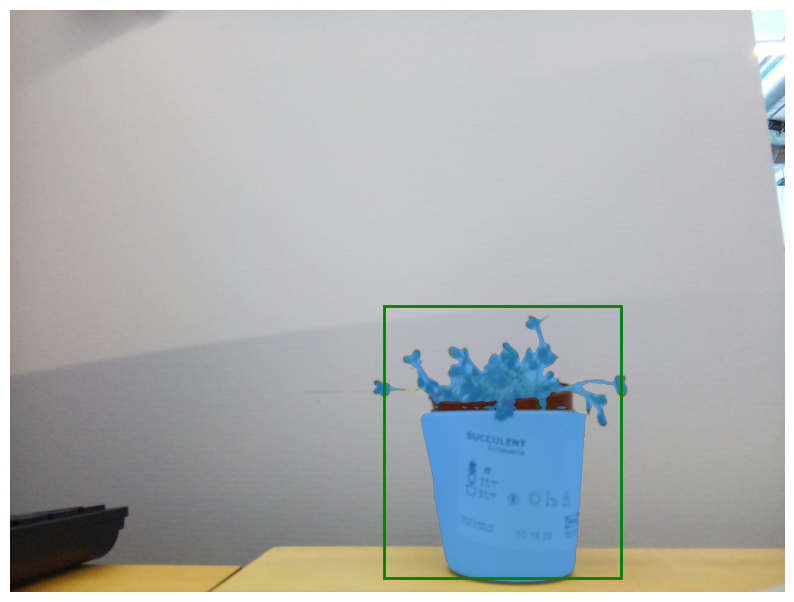

In [90]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [91]:
detections = detection_result.detections
for detection in detections:
    if 'plant' in detection.categories[0].category_name.lower():
        box = detection.bounding_box

input_box = np.array([box.origin_x, box.origin_y, box.origin_x+box.width, box.origin_y+box.height])

# Print the width and height of the bounding box
print("Width:", box.width)
print("Height:", box.height)


Width: 1004
Height: 1149
